In [2]:
if False:
    !sudo pip3 install pyro-ppl -q
    !sudo pip3 install seaborn -q
    !wget http://files.grouplens.org/datasets/movielens/ml-100k.zip
    !unzip ml-100k.zip
    !mkdir data
    !mkdir data/100k
    !mv ml-100k/* data/100k

In [1]:
import pyro
import spotlight
import pandas as pd
import seaborn
from spotlight.cross_validation import random_train_test_split
from spotlight.datasets.movielens import get_movielens_dataset
from spotlight.evaluation import rmse_score
from spotlight.factorization.explicit import ExplicitFactorizationModel
import torch

import numpy as np
import matplotlib.pyplot as plt
import math
import os
import torch
import torch.distributions.constraints as constraints
import pyro
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO
import pyro.distributions as dist
from pyro import plate
import matplotlib.pyplot as plt


from torch import nn

def get_device(device = None):
    if device is not None:
        return torch.device(device)
    if torch.cuda.is_available():
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")
    return device
device = get_device("cpu")

In [2]:
device

device(type='cpu')

In [3]:
from spotlight.interactions import Interactions
import pandas as pd

dat = pd.read_csv("data/100k/u.data", sep ="\t", names = ['userId','itemId','rating','timestamp'])

items = pd.read_csv("data/100k/u.item", sep = "\|", names = ["itemId", "name", "release date", "video release date",
              "IMDb URL", "unknown", "Action", "Adventure", "Animation",
              "Children's", "Comedy", "Crime", "Documentary", "Drama", "Fantasy",
              "Film-Noir", "Horror", "Musical", "Mystery", "Romance", "Sci-Fi",
              "Thriller", "War", "Western"], engine="python")

item_genre_vector = items.iloc[:,5:].values
items = items[['itemId','name']]

In [4]:
ds = Interactions(item_ids=torch.tensor(dat.itemId),
            user_ids = torch.tensor(dat.userId),
            ratings=torch.tensor(dat.rating).float(),
            timestamps=torch.tensor(dat.timestamp))

/usr/local/lib/python3.6/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Total length of dataset 100000
num users: 944, num items: 1683


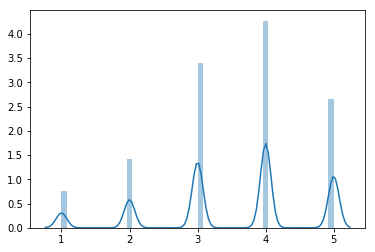

In [5]:
ind2item = {row.itemId : row.name for row in items.itertuples()}

train, test = random_train_test_split(ds)

_ =seaborn.distplot(ds.ratings)
print(f"Total length of dataset {len(ds.ratings)}")
print(f"num users: {ds.num_users}, num items: {ds.num_items}")

## pyro implementation

In [6]:
class SVI_MF(nn.Module):
    """
    A module that contains a model, a guide and a predict function to get expected predictions of user and item ratings."""
    
    def __init__(self, d = 2):
        super(SVI_MF, self).__init__()
        self.d = d
        
        
        #self.cuda()
        
    def predict(self, user_ids, item_ids):
        uservec = pyro.param("Z").detach()[user_ids]
        itemvec = pyro.param("V").detach()[item_ids]
        preds = (uservec * itemvec).sum(1)
        return preds
        
    def model(self, dat):
        mu0 = torch.zeros(self.d).to(device)
        var0 = torch.diag(torch.ones(self.d)).to(device)*0.2

        muZ = pyro.sample("muZ", dist.MultivariateNormal(loc = mu0, covariance_matrix= var0))
        muV = pyro.sample("muV", dist.MultivariateNormal(loc = mu0, covariance_matrix= var0))
        varZ = varV = var0

        with plate("user_loop", dat.num_users) as i:
            Z = pyro.sample(f"z_", dist.MultivariateNormal(muZ, varZ))

        with plate("item_loop", dat.num_items) as i:
            V = pyro.sample(f"v_", dist.MultivariateNormal(muV, varV)) 


        with plate("data_loop", size = len(dat.ratings)) as k:
            z = Z[dat.user_ids[k]]
            v = V[dat.item_ids[k]]
            score = z.mul(v).sum(1)
            r = dat.ratings[k].to(device)
            pyro.sample(f"obs", dist.Normal(loc = score, scale = 1.0), obs=r)
            
    def guide(self, dat):
        varZ = pyro.param("varZ", torch.ones(self.d), constraint = constraints.positive).to(device)
        user_var = pyro.param("user_var_factor", torch.rand(dat.num_users)+0.5, constraint = constraints.positive).to(device)
        covarZ = torch.diag(varZ)*user_var.view(-1,1,1)

        varV = pyro.param("varV", torch.ones(self.d), constraint = constraints.positive).to(device)
        item_var = pyro.param("item_var_factor", torch.rand(dat.num_items)+0.5, constraint = constraints.positive).to(device)
        covarV = torch.diag(varV)*item_var.view(-1,1,1)

        muZpar = pyro.param("muZpar", torch.rand(self.d)-0.5).to(device)
        muVpar = pyro.param("muVpar", torch.rand(self.d)-0.5).to(device)

        # Global vars:
        muZ = pyro.sample("muZ", dist.MultivariateNormal(loc = muZpar, covariance_matrix= covarZ)).to(device) ## NBNB HERE THE GLOBAL THING IS DEPENDENT ON ALL DIFFERENT VARS
        muV = pyro.sample("muV", dist.MultivariateNormal(loc = muVpar, covariance_matrix= covarV)).to(device) ## NBNB HERE THE GLOBAL THING IS DEPENDENT ON ALL DIFFERENT VARS

        ## user latent vectors
        Z = pyro.param("Z", torch.rand(dat.num_users, self.d)-0.5).to(device)
        V = pyro.param("V", torch.rand(dat.num_items, self.d)-0.5).to(device)


        with plate("user_loop", dat.num_users) as i:
            Z = pyro.sample(f"z_", dist.MultivariateNormal(Z[i,], covarZ[i,])).to(device)


        ## item latent vectors
        with plate("item_loop", dat.num_items) as i:
            V = pyro.sample(f"v_", dist.MultivariateNormal(V[i,], covarV)).to(device)
            
svi_mf = SVI_MF(d=2).to(device)

In [7]:
svi_mf.model(train)

In [8]:
%%time
n_steps = 200
pyro.clear_param_store()

# set up the optimizer
adam_params = {"lr": 0.05}
optimizer = Adam(adam_params)

# setup the inference algorithm
svi = SVI(svi_mf.model, svi_mf.guide, optimizer, loss=Trace_ELBO())

# do gradient steps
for step in range(n_steps):
    loss = svi.step(train)

    if step%10== 0:
        # RMSE
        rmse_test = rmse_score(svi_mf, test)
        print(f"step: {step} \t loss: {loss:.0f} \t test-rmse: {rmse_test:.2f}")

step: 0 	 loss: 764800 	 test-rmse: 3.70
step: 10 	 loss: 615288 	 test-rmse: 3.70
step: 20 	 loss: 419806 	 test-rmse: 3.70
step: 30 	 loss: 214529 	 test-rmse: 3.72
step: 40 	 loss: 202469 	 test-rmse: 3.72
step: 50 	 loss: 179760 	 test-rmse: 3.71
step: 60 	 loss: 172214 	 test-rmse: 3.71
step: 70 	 loss: 167979 	 test-rmse: 3.72
step: 80 	 loss: 163702 	 test-rmse: 3.71
step: 90 	 loss: 165943 	 test-rmse: 3.71
step: 100 	 loss: 161692 	 test-rmse: 3.71
step: 110 	 loss: 164638 	 test-rmse: 3.71
step: 120 	 loss: 162114 	 test-rmse: 3.71
step: 130 	 loss: 162630 	 test-rmse: 3.71
step: 140 	 loss: 164808 	 test-rmse: 3.71
step: 150 	 loss: 159912 	 test-rmse: 3.71
step: 160 	 loss: 161627 	 test-rmse: 3.71
step: 170 	 loss: 159887 	 test-rmse: 3.71
step: 180 	 loss: 158628 	 test-rmse: 3.71
step: 190 	 loss: 160722 	 test-rmse: 3.71
CPU times: user 1min 30s, sys: 1.36 s, total: 1min 31s
Wall time: 1min 31s


## Print uncertainty factors vs number of activity on user and items

User activity/uncertainty correlation: -0.64


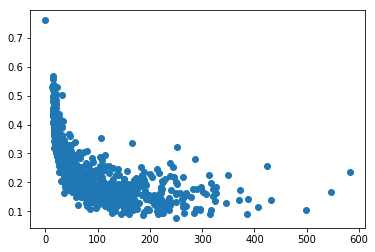

Item activity/uncertainty correlation: -0.64


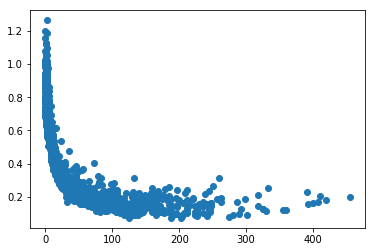

In [15]:
def get_counts(sequence, num):
    ids, id_count = np.unique(sequence, return_counts=True)
    counts = np.zeros(num)
    counts[ids] = id_count
    return counts

user_counts = get_counts(train.user_ids, train.num_users)#[1:]
user_factors = pyro.param("user_var_factor").detach().numpy()#[1:]
print(f"User activity/uncertainty correlation: {np.corrcoef(user_factors, user_counts)[1,0]:.2f}")
_ = plt.plot(user_counts, user_factors, "o")
plt.show()

item_counts = get_counts(train.item_ids, train.num_items)
item_factors = pyro.param("item_var_factor").detach().numpy()
print(f"Item activity/uncertainty correlation: {np.corrcoef(item_factors, item_counts)[1,0]:.2f}")
_ = plt.plot(item_counts, item_factors, "o")
plt.show()

# Plot distribution of user vectors

Random users:


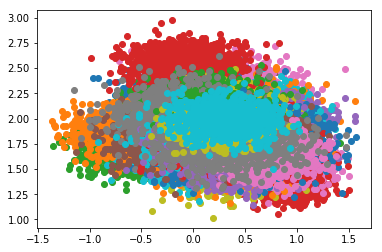

Most and least seen user:


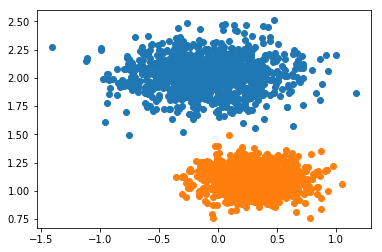

In [16]:
def plot_distr_of_users(u):
    u_means = pyro.param("user_mat")[u,]
    u_covars = torch.diag(pyro.param("varU")) * (pyro.param("user_var_factor")[u,].view(-1,1,1))
    user_distr = torch.distributions.MultivariateNormal(u_means, u_covars)

    samples = user_distr.sample(torch.tensor([1000])).numpy()
    for u in range(len(u)):
        plt.plot(samples[:,u,0], samples[:,u,1], "o")
        

print("Random users:")
u = torch.randint(low=0, high=train.num_users, size = (50,))
plot_distr_of_users(u)
plt.show()

u = np.array([user_counts.argsort()[1], user_counts.argmax()])
print("Most and least seen user:")
plot_distr_of_users(u)

Random items:


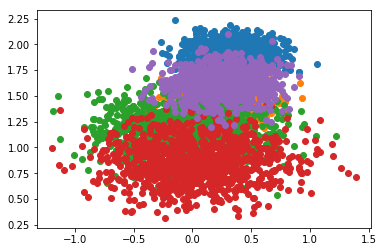

Most and least seen item:


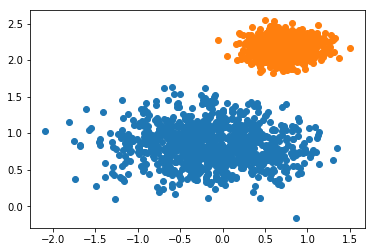

In [17]:
u = torch.randint(low=0, high=train.num_items, size = (5,))
def plot_distr_of_items(u):
    u_means = pyro.param("item_mat")[u,]
    u_covars = torch.diag(pyro.param("varV")) * (pyro.param("item_var_factor")[u,].view(-1,1,1))
    user_distr = torch.distributions.MultivariateNormal(u_means, u_covars)

    samples = user_distr.sample(torch.tensor([1000])).numpy()
    for u in range(len(u)):
        plt.plot(samples[:,u,0], samples[:,u,1], "o")

print("Random items:")
plot_distr_of_items(u)
plt.show()

u = np.array([item_counts.argsort()[1], item_counts.argmax()])
print("Most and least seen item:")
plot_distr_of_items(u)